# Variable distribution

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from pyprojroot import here
import matplotlib.pyplot as plt
import altair as alt
import polars as pl

from gpfa_imputation.gap_finder import scan_fluxnet_csv

from gpfa_imputation.utils import cache_disk

## Load

load Hainich dataset

In [ ]:
hai_path = here("data") / "FLX_DE-Hai_FLUXNET2015_FULLSET_HH_2000-2012_1-4.csv"
# hai_raw = pd.read_csv(here("data") / hai_path, na_values=["-9999", "-9999.99"], parse_dates=[0, 1], nrows=20_000)

In [ ]:
meteo_vars = {
    "TA_F": "TA",
    "SW_IN_F": "SW_IN",
    "LW_IN_F": "LW_IN",
    "VPD_F": "VPD",
    #"PA": "PA"
}

units = {
    'TA': '°C',
    'SW_IN': 'W m-2',
    'LW_IN': 'W m-2',
    'VPD': 'hPa'
}

hai = scan_fluxnet_csv(hai_path, convert_dates=True).rename(meteo_vars).select([pl.col("end").alias("time"), *meteo_vars.values()])

hai.fetch(10)

time,TA,SW_IN,LW_IN,VPD
datetime[μs],f64,f64,f64,f64
2000-01-01 00:30:00,-0.6,0.0,302.475,0.222
2000-01-01 01:00:00,-0.65,0.0,302.475,0.122
2000-01-01 01:30:00,-0.58,0.0,301.677,0.09
2000-01-01 02:00:00,-0.51,0.0,301.677,0.11
2000-01-01 02:30:00,-0.49,0.0,301.677,0.102
2000-01-01 03:00:00,-0.4,0.0,301.677,0.111
2000-01-01 03:30:00,-0.36,0.0,301.677,0.109
2000-01-01 04:00:00,-0.35,0.0,301.677,0.107
2000-01-01 04:30:00,-0.28,0.0,308.046,0.122


In [ ]:
hai_td = hai.melt('time')

In [ ]:
hai_td.fetch(3)

time,variable,value
datetime[μs],str,f64
2000-01-01 00:30:00,"""TA""",-0.6
2000-01-01 01:00:00,"""TA""",-0.65
2000-01-01 01:30:00,"""TA""",-0.58
2000-01-01 00:30:00,"""SW_IN""",0.0
2000-01-01 01:00:00,"""SW_IN""",0.0
2000-01-01 01:30:00,"""SW_IN""",0.0
2000-01-01 00:30:00,"""LW_IN""",302.475
2000-01-01 01:00:00,"""LW_IN""",302.475
2000-01-01 01:30:00,"""LW_IN""",301.677


## Distribution

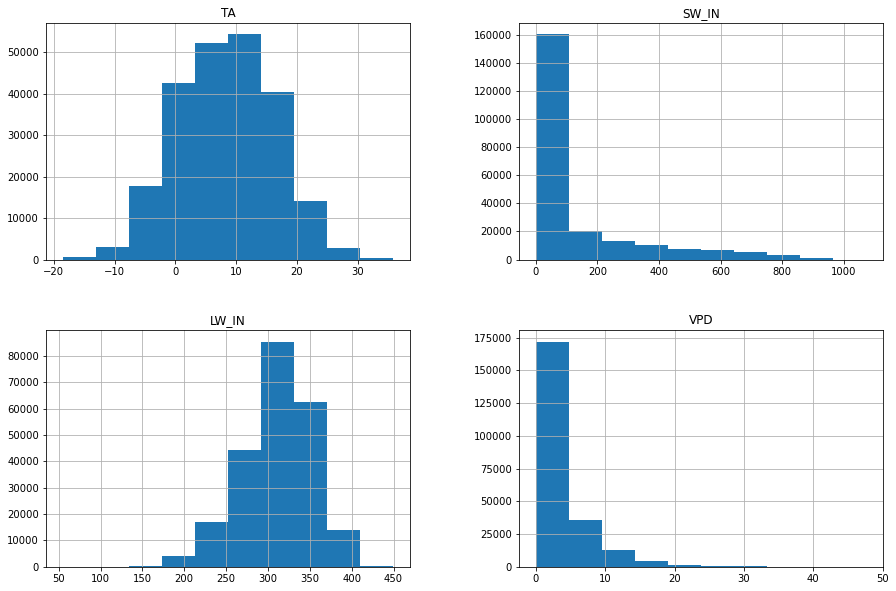

In [ ]:
hai.drop('time').collect().to_pandas().hist(figsize=(15,10));

In [ ]:
# should to the binning before the plot
# alt.Chart(hai_td.collect().to_pandas()).mark_line().encode(
#     x = 'value',
#     y = 'density()',
#     facet = alt.Facet('variable', columns=2)
# )

## Correlation

Code inspired from source: https://towardsdatascience.com/altair-plot-deconstruction-visualizing-the-correlation-structure-of-weather-data-38fb5668c5b1

In [ ]:
hai_p = hai.collect().to_pandas().set_index('time')

In [ ]:
hai_p.corr()

,TA,SW_IN,LW_IN,VPD
TA,1.000000,0.432321,0.639556,0.735412
SW_IN,0.432321,1.000000,0.126278,0.533506
LW_IN,0.639556,0.126278,1.000000,0.270424
VPD,0.735412,0.533506,0.270424,1.000000


In [ ]:
def corr_mask(size):
    corr_mask = np.zeros((size,size), dtype=bool)
    for i in range(size):
        for j in range(size):
            corr_mask[i,j] = True if i >= j else False
    return corr_mask

In [ ]:
corr_mask(len(hai_p.columns))

array([[ True, False, False, False],
       [ True,  True, False, False],
       [ True,  True,  True, False],
       [ True,  True,  True,  True]])

In [ ]:
hai_p = hai_p[sorted(hai_p.columns)] # need to properly plot half a corr matrix

In [ ]:
cor_hai = (hai_p
              .corr().mask(~corr_mask(len(hai_p.columns))).stack()
              .reset_index()     # The stacking results in an index on the correlation values, we need the index as normal columns for Altair
              .rename(columns={0: 'correlation', 'level_0': 'variable', 'level_1': 'variable2'}))
cor_hai['correlation_label'] = cor_hai['correlation'].map('{:.2f}'.format)  # Round to 2 decimal
cor_hai

,variable,variable2,correlation,correlation_label
0,LW_IN,LW_IN,1.000000,1.00
1,SW_IN,LW_IN,0.126278,0.13
2,SW_IN,SW_IN,1.000000,1.00
3,TA,LW_IN,0.639556,0.64
4,TA,SW_IN,0.432321,0.43
5,TA,TA,1.000000,1.00
6,VPD,LW_IN,0.270424,0.27
7,VPD,SW_IN,0.533506,0.53
8,VPD,TA,0.735412,0.74
9,VPD,VPD,1.000000,1.00


In [ ]:
import numpy as np

def compute_2d_histogram(var1, var2, df, density=True, bins=20):
    H, xedges, yedges = np.histogram2d(df[var1], df[var2], bins=bins, density=density)
    H[H == 0] = np.nan

    # Create a nice variable that shows the bin boundaries
    
    x_width = xedges[1] - xedges[0] # all bins have same width
    xedges = pd.Series(xedges[:-1] + x_width /2)
    
    y_width = yedges[1] - yedges[0] # all bins have same width
    yedges = pd.Series(yedges[:-1] + y_width /2)
    
    # Cast to long format using melt
    res = pd.DataFrame(H, 
                       index=yedges, 
                       columns=xedges).reset_index().melt(
                            id_vars='index'
                       ).rename(columns={'index': 'value2', 
                                         'value': 'count',
                                         'variable': 'value'})
    

    res['variable'] = var1
    res['variable2'] = var2 
    return res.dropna() # Drop all combinations for which no values where found

In [ ]:
h, xe, ye = np.histogram2d(hai_p['VPD'], hai_p['TA'])

In [ ]:
x_width = xe[1] - xe[0] # all bins have same width
xe = pd.Series(xe + x_width /2)

In [ ]:
h.shape

(10, 10)

In [ ]:
xe

0      2.38335
1      7.15005
2     11.91675
3     16.68345
4     21.45015
5     26.21685
6     30.98355
7     35.75025
8     40.51695
9     45.28365
10    50.05035
dtype: float64

In [ ]:
hai_binned = pd.concat([compute_2d_histogram(var1, var2, hai_p) for var1 in meteo_vars.values() for var2 in meteo_vars.values()])
hai_binned.head()

,value2,value,count,variable,variable2
0,-17.19025,-17.19025,0.000083,TA,TA
21,-14.47075,-14.47075,0.000224,TA,TA
42,-11.75125,-11.75125,0.000574,TA,TA
63,-9.03175,-9.03175,0.001188,TA,TA
84,-6.31225,-6.31225,0.003781,TA,TA


In [ ]:
# Define selector
var_sel_cor = alt.selection_single(fields=['variable', 'variable2'], clear=False, 
                                  init={'variable': 'TA', 'variable2': 'SW_IN'})

# Define correlation heatmap
base = alt.Chart(cor_hai).encode(
    x='variable2:O',
    y='variable:O'    
)

text = base.mark_text().encode(
    text='correlation_label',
    color=alt.condition(
        alt.datum.correlation > 0.5, 
        alt.value('white'),
        alt.value('black')
    )
)

cor_plot = base.mark_rect().encode(
    color=alt.condition(var_sel_cor, alt.value('pink'), 'correlation:Q')
).add_selection(var_sel_cor)

# Define 2d binned histogram plot
scat_plot = alt.Chart(hai_binned).transform_filter(
    var_sel_cor
).mark_rect().encode(
    alt.X('value:N', axis=alt.Axis(format=".4")), 
    alt.Y('value2:N', axis=alt.Axis(format=".4"), sort='descending'),
    alt.Color('count:Q', scale=alt.Scale(scheme='blues'))
)

# Combine all plots. hconcat plots both side-by-side 
alt.hconcat((cor_plot + text).properties(width=350, height=350), scat_plot.properties(width=350, height=350)).resolve_scale(color='independent')

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.HConcatChart(...)

In [ ]:
hai_p = hai.collect().to_pandas().set_index('time')

In [ ]:
hai_td_p = hai_td.collect().to_pandas().set_index('time')